Importing python libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pyriemann.estimation import Covariances
from pyriemann.tangentspace import TangentSpace
from pyriemann.utils.mean import mean_covariance
from pyriemann.estimation import XdawnCovariances
from pyriemann.embedding import SpectralEmbedding
from sklearn.metrics.pairwise import cosine_similarity
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.model_selection import train_test_split
from pyriemann.utils.viz import plot_embedding
plt.ion()

Defining a function which generates random noise having specific spectral properties (mirroring a power spectral density) 

In [2]:
def fftnoise(f, random_seed=0):

    np.random.seed(random_seed)
    f = np.array(f, dtype='complex')
    Np = (len(f) - 1) // 2
    phases = np.random.rand(Np) * 2 * np.pi
    phases = np.cos(phases) + 1j * np.sin(phases)
    f[1:Np+1] *= phases
    f[-1:-1-Np:-1] = np.conj(f[1:Np+1])

    return np.fft.ifft(f).real

Defining a function which generates random noise in a specific frequency band (band-limited noise)

In [3]:
def band_limited_noise(min_freq, max_freq, samples=1024, samplerate=1024, random_seed=0):

    freqs = np.abs(np.fft.fftfreq(samples, 1/samplerate))
    f = np.zeros(samples)
    idx = np.where(np.logical_and(freqs>=min_freq, freqs<=max_freq))[0]
    f[idx] = 1

    return fftnoise(f, random_seed)

Defining a function which generates pink noise (one over f power distribution, higher power for lower frequencies, lower power for higher frequencies)

In [4]:
def one_over_f_noise(max_freq, samples=1024, samplerate=1024, random_seed=0):

	freqs = np.abs(np.fft.fftfreq(samples, 1/samplerate))
	f = np.zeros(samples)
	f[1:] = np.array([1/np.sqrt(freqs[ii]) for ii in range(1,len(freqs))])

	return fftnoise(f, random_seed)

Defining a function which generates a simulated trial consisting of a combination of signal plus noise in three different channels. The signal onset and offset can be defined such that the signal is temporally aligned or misaligned across trials)

In [5]:
def generate_trial(t, snr=0.9, sigma=2, t_start=0.3, t_stop=0.5, resp_frq=0.03, factor=1.0, noise_type='white', trial_type='evoked', random_seed=0):

    np.random.seed(random_seed)
    t_step = np.diff(t).mean()
    t0 = np.round(t_start*np.max(t),0)
    t1 = np.round(t_stop*np.max(t),0)
    t_response = np.arange(t0, t1, t_step)
    if trial_type == 'evoked':
    	response = np.sin(t_response * (2 * np.pi / (t1-t0)) - t0 * (2 * np.pi / (t1-t0))) 
    	if factor > 0:
    		response[:len(response)//2] *= factor 
    	else:
    		response[len(response)//2:] *= np.abs(factor) 
    	x = np.zeros(t.size)
    	x[(t >= t0) * (t < t1)] += response
    elif trial_type == 'induced':
    	x = np.zeros(t.size)
    	tmp = (t >= t0) * (t < t1)
    	x[tmp] += np.sin(t_response * (resp_frq * 2 * np.pi))
    	x[tmp] *= np.sin(t_response * (np.pi / (t1-t0)) - t0 * (np.pi / (t1-t0)))
    	x *= sigma
    if noise_type == 'white':
    	noise = np.random.normal(loc=0.0, scale=sigma * (1-snr), size=t.size)
    elif noise_type == 'oneoverf':
    	noise = one_over_f_noise(125, samples=len(t), samplerate=len(t)//1, random_seed=random_seed)
    	noise /= noise.std()
    	noise *= sigma*(1-snr)
    bkgnoise = band_limited_noise(1, 125, samples=len(t), samplerate=len(t)//1, random_seed=random_seed)
    bkgnoise /= bkgnoise.std()
    bkgnoise *= sigma*(1-snr)
    x = x * sigma * snr + noise + bkgnoise

    return x

Defining a function which plots the simulated data

In [6]:
def plot_trials(XX, t, max_subplots=8, color='r', condition=1, linewidth=3):

    n_trials = XX.shape[0]
    n_sensors = XX.shape[1]
    fig, axs = plt.subplots(max_subplots, 1,
                            sharex=True, sharey=True)
    fig.set_figheight(14)
    fig.set_figwidth(6)
    fig.set_facecolor('w')
    fig.set_edgecolor('k')
    offset = np.flip(np.array([-1,2,5])) 
    color = [color] * n_sensors
    signal_max = 0.0
    for i in range(n_trials):
        for j in range(n_sensors):
            if i < max_subplots:
                axs[i].tick_params(labelsize=22)
                axs[i].plot(t, XX[i, j] + offset[j], color[j])
                axs[i].set_ylabel('Trial %d' % (i+1), fontsize=26)
                if np.abs(XX[i, j]).max() > signal_max:
                    signal_max = np.abs(XX[i, j]).max()
            else:
                continue

        plt.ylim([offset.min() - signal_max, offset.max() + signal_max])

    plt.yticks(np.flip(np.array([-1,2,5])), labels=['C1', 'C2', 'C3'])
    plt.xticks(np.arange(0,6001,1000), labels=np.arange(0,7,1))
    plt.xlabel('Time [s]', fontsize=26)
    plt.suptitle('Simulated Condition %d' % condition, fontsize=30)
    fig.tight_layout()

    return XX

Defining variables

In [7]:
simtype = 'misaligned' # 'aligned' # 
t = np.arange(0,6001,1)
n_trials = 100
scoring = 'roc_auc' 
solver = 'liblinear'
tol = 1.0e-3
n_jobs = -1
n_folds = 5

Simulating data

In [8]:
XX1 = np.zeros((n_trials, 3, len(t)))
d1 = np.random.uniform(0.0,0.2,100)
d2 = np.random.uniform(0.0,0.2,100)
d3 = np.random.uniform(0.0,0.3,100)
d4 = np.random.uniform(0.0,0.3,100)
for ii in range(n_trials):
    np.random.seed(ii*np.random.randint(0,10))
    XX1[ii,0,:] = generate_trial(t, snr=0.9, sigma=1.0, t_start=0.2+d1[ii], t_stop=0.4+d1[ii], resp_frq=0.02, factor=np.random.uniform(2,1), noise_type='oneoverf', trial_type='evoked', random_seed=(ii+1)*np.random.randint(0,100))
    XX1[ii,1,:] = generate_trial(t, snr=0.9, sigma=1.0, t_start=0.2+d2[ii], t_stop=0.4+d2[ii], resp_frq=0.02, factor=np.random.uniform(2,1), noise_type='oneoverf', trial_type='evoked', random_seed=(ii+2)*np.random.randint(0,100))
    XX1[ii,2,:] = generate_trial(t, snr=0, sigma=0.1, t_start=d3[ii], t_stop=d4[ii], factor=0, resp_frq=np.random.uniform(0,1), noise_type='oneoverf', trial_type='evoked', random_seed=(ii+3)*np.random.randint(0,100))

XX2 = np.zeros((n_trials, 3, len(t)))
d1 = np.random.uniform(0.0,0.2,100)
d2 = np.random.uniform(0.0,0.2,100)
d3 = np.random.uniform(0.0,0.3,100)
d4 = np.random.uniform(0.0,0.3,100)
for ii in range(n_trials):
    np.random.seed(ii*np.random.randint(0,10))
    XX2[ii,0,:] = generate_trial(t, snr=0.9, sigma=1.0, t_start=0.2+d1[ii], t_stop=0.4+d1[ii], resp_frq=0.02, factor=np.random.uniform(2,1), noise_type='oneoverf', trial_type='evoked', random_seed=(ii+1)*np.random.randint(0,100))
    XX2[ii,1,:] = generate_trial(t, snr=0, sigma=0.1, t_start=d3[ii], t_stop=d4[ii], resp_frq=np.random.uniform(0,1), factor=0.0, noise_type='oneoverf', trial_type='evoked', random_seed=(ii+2)*np.random.randint(0,100))
    XX2[ii,2,:] = generate_trial(t, snr=0.9, sigma=1.0, t_start=0.2+d2[ii], t_stop=0.4+d2[ii], resp_frq=0.02, factor=np.random.uniform(2,1), noise_type='oneoverf', trial_type='evoked', random_seed=(ii+3)*np.random.randint(0,100))

Plotting data for simulated condition 1

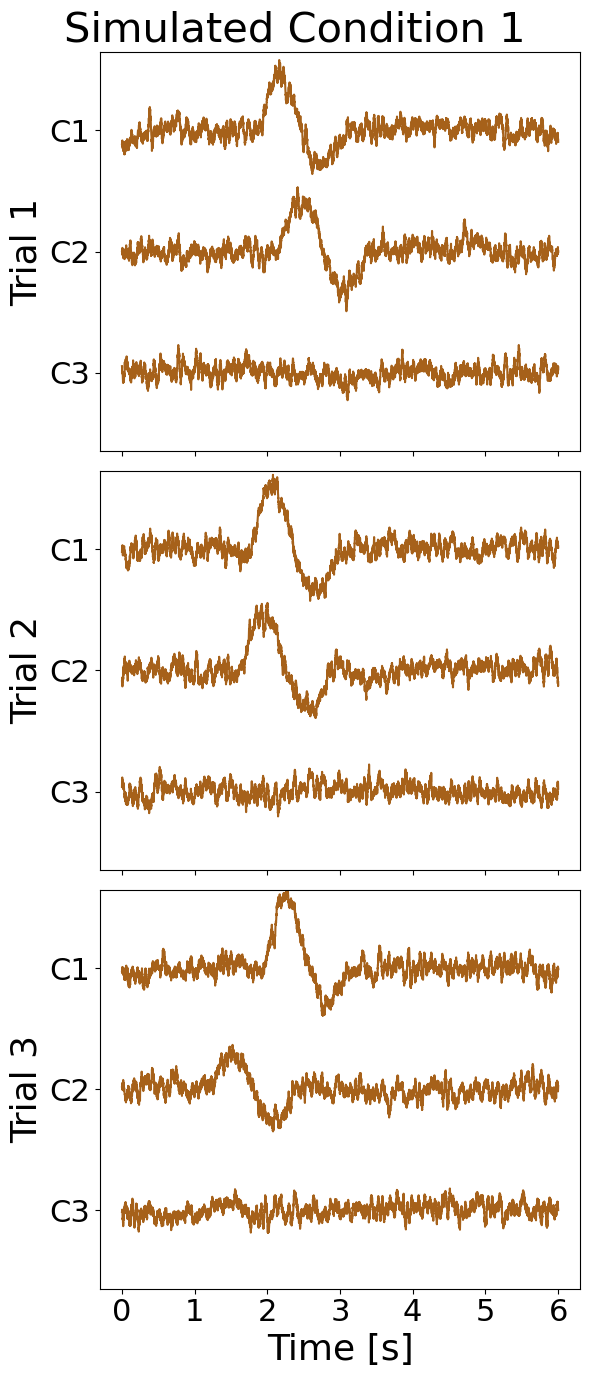

In [12]:
X1 = plot_trials(XX1,t,max_subplots=3, color='#a6611a', condition=1)

Plotting data for simulated condition 2

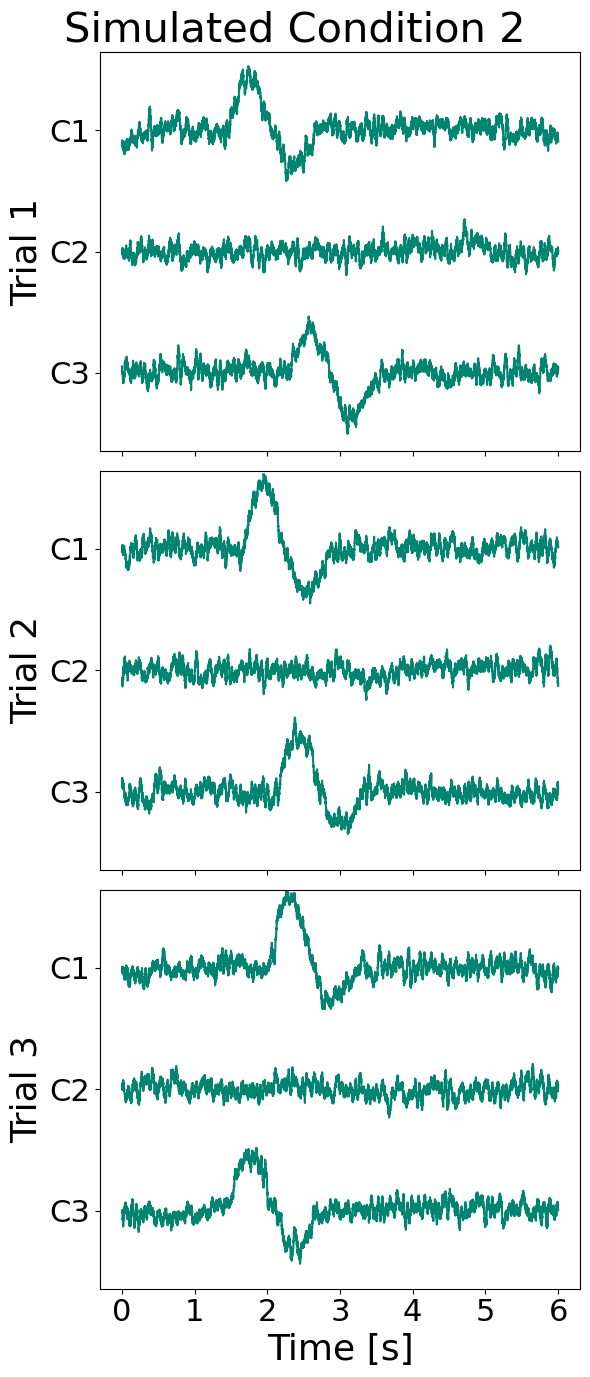

In [13]:
X2 = plot_trials(XX2,t,max_subplots=3, color='#018571', condition=2)
YS = np.concatenate((np.zeros(100),np.ones(100)))

Defining sliding time window

In [14]:
t_min = 1200  
t_max = 2400  
time_window_size = 100  
time_step = 100  
epsilon = 10  
t_mins = np.arange(t_min, t_max - time_window_size + epsilon, time_step)
t_maxs = np.arange(t_min + time_window_size, t_max + epsilon, time_step)
time_windows = zip(t_mins, t_maxs)

Plotting single time series for each simulated channel

(-2.0, 2.0)

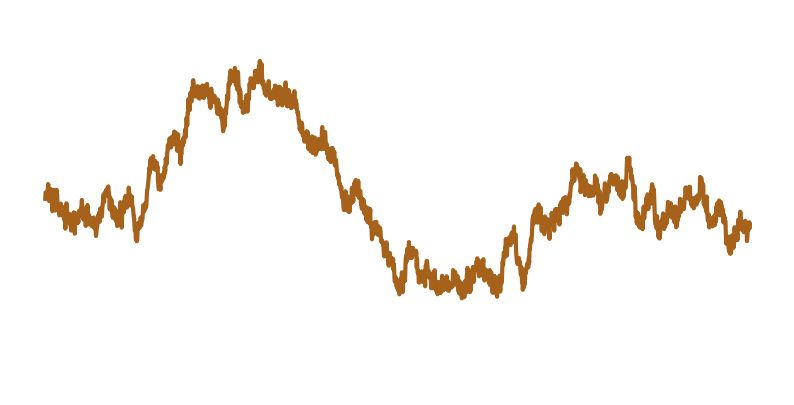

In [15]:
plt.figure(figsize=(10,5))
ax = plt.subplot(111)
ax.plot(np.linspace(1,3,2000), X1[4,0,1000:3000], color='#a6611a', lw=3)
ax.axis('off')
ax.set_ylim([-2,2])

(-2.0, 2.0)

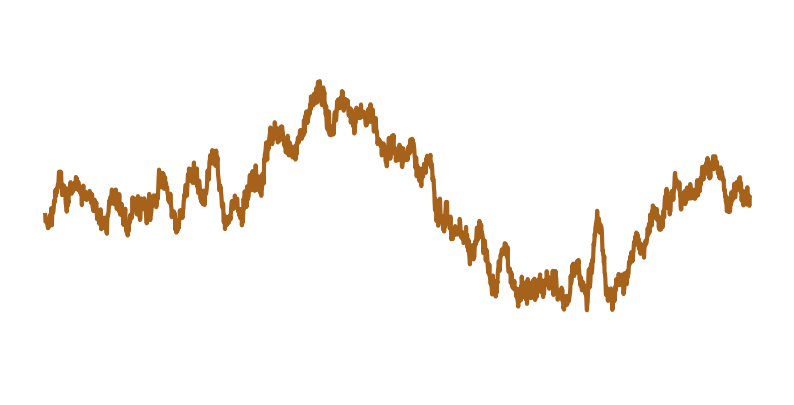

In [16]:
plt.figure(figsize=(10,5))
ax = plt.subplot(111)
ax.plot(np.linspace(1,3,2000), X1[4,1,1000:3000], color='#a6611a', lw=3)
ax.axis('off')
ax.set_ylim([-2,2])

(-2.0, 2.0)

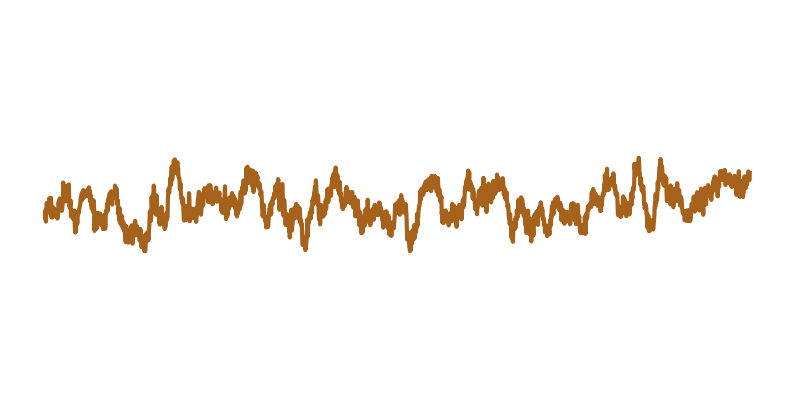

In [17]:
plt.figure(figsize=(10,5))
ax = plt.subplot(111)
ax.plot(np.linspace(1,3,2000), X1[4,2,1000:3000], color='#a6611a', lw=3)
ax.axis('off')
ax.set_ylim([-2,2])

(-2.0, 2.0)

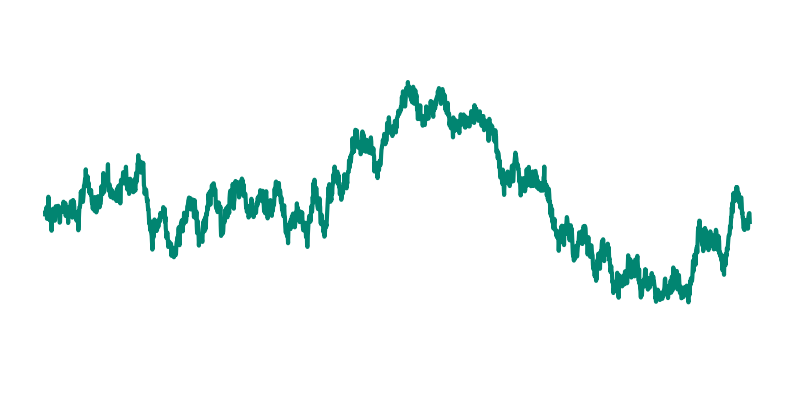

In [18]:
plt.figure(figsize=(10,5))
ax = plt.subplot(111)
ax.plot(np.linspace(1,3,2000), X2[3,0,1000:3000], color='#018571', lw=3)
ax.axis('off')
ax.set_ylim([-2,2])

(-2.0, 2.0)

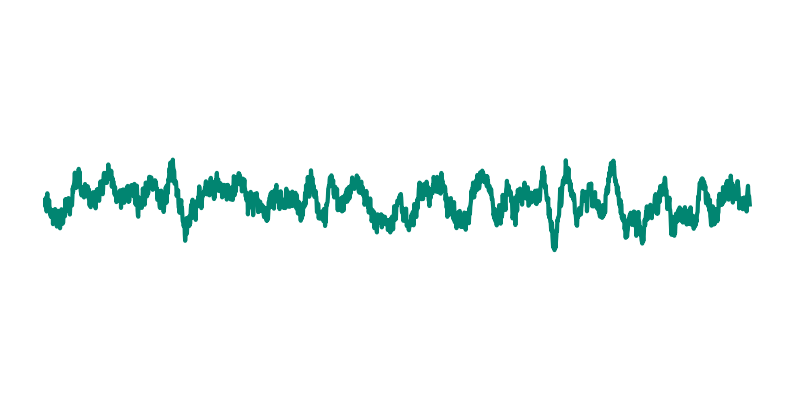

In [19]:
plt.figure(figsize=(10,5))
ax = plt.subplot(111)
ax.plot(np.linspace(1,3,2000), X2[3,1,1000:3000], color='#018571', lw=3)
ax.axis('off')
ax.set_ylim([-2,2])

(-3.0, 3.0)

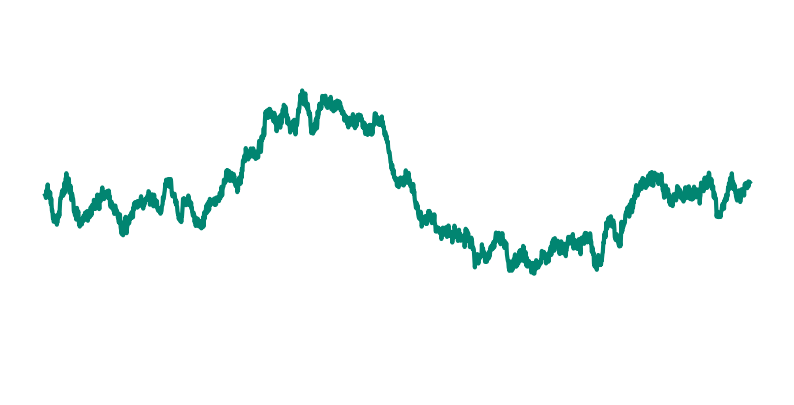

In [20]:
plt.figure(figsize=(10,5))
ax = plt.subplot(111)
ax.plot(np.linspace(1,3,2000), X2[3,2,1000:3000], color='#018571', lw=3)
ax.axis('off')
ax.set_ylim([-3,3])

Plot a cosine similarity matrix showing the similarity between vector pairs in the time domain for each simulated condition

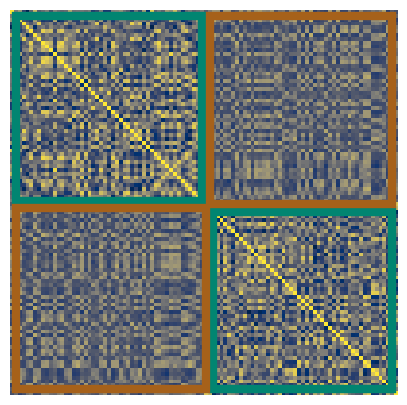

In [23]:
fig, ax = plt.subplots(figsize=(5, 5))
cosim = cosine_similarity(np.concatenate([X1[:50,:,1000:3000].reshape(50,6000),X2[:50,:,1000:3000].reshape(50,6000)]))
ax.imshow(cosim,cmap='cividis',aspect='auto')
ax.axis('off')
rect1 = patches.Rectangle((1, 1), 48, 48, linewidth=6, edgecolor='#018571', facecolor='none')
rect2 = patches.Rectangle((52, 52), 46, 46, linewidth=6, edgecolor='#018571', facecolor='none')
rect3 = patches.Rectangle((1, 51), 49, 47, linewidth=6, edgecolor='#a6611a', facecolor='none')
rect4 = patches.Rectangle((51, 1), 47, 49, linewidth=6, edgecolor='#a6611a', facecolor='none')
ax.add_patch(rect1)
ax.add_patch(rect2)
ax.add_patch(rect3)
ax.add_patch(rect4)

Plot a cosine similarity distribution showing the similarity between vector pairs in the time domain for each simulated condition

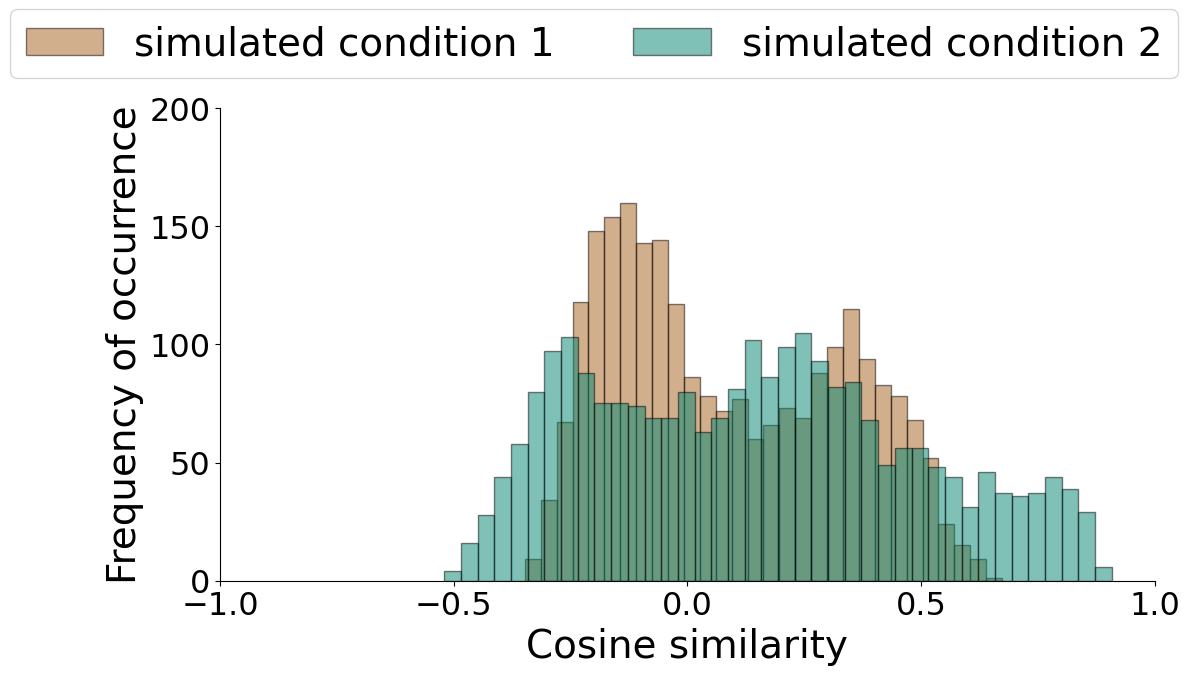

In [24]:
if simtype=='aligned':
    simpar = dict(bins=[33,13], ylim=[0,600], yticks=[0,100,200,300,400,500,600])
else:
    simpar = dict(bins=[30,40], ylim=[0,200], yticks=[0,50,100,150,200])
fig, ax = plt.subplots(figsize=(12, 7))
ax.hist(cosim[1:50,51:100].ravel(),bins=simpar['bins'][0],color='#a6611a',edgecolor='k', alpha=0.5, label='simulated condition 1')
ax.hist(np.concatenate((cosim[0:50,0:50][np.triu_indices(50,1)],cosim[50:100,50:100][np.triu_indices(50,1)])),bins=simpar['bins'][1],color='#018571',edgecolor='k',alpha=0.5, label='simulated condition 2')
ax.set_xlabel('Cosine similarity', fontsize=28)
ax.set_ylabel('Frequency of occurrence', fontsize=28)	
ax.tick_params(labelsize=25)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.tick_params(labelsize=23)
ax.set_ylim(simpar['ylim'])
ax.set_xlim([-1,1])
ax.set_yticks(simpar['yticks'])
ax.set_xticks([-1,-0.5,0,0.5,1])
ax.legend(loc=9,bbox_to_anchor=(0.4, 1.25),ncol=2,fontsize=28)
plt.tight_layout(pad=1)

Estimating spatial covariance matrices

In [25]:
C1 = Covariances(estimator='oas').fit_transform(X1[:,:,1000:3000])
C2 = Covariances(estimator='oas').fit_transform(X2[:,:,1000:3000])

Plotting average spatial covariance matrix for simulated codition 1

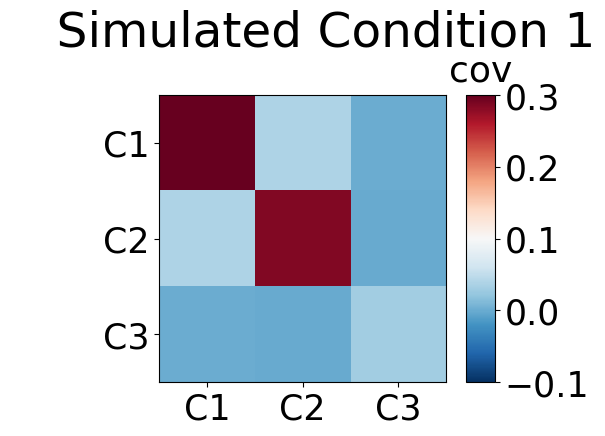

In [29]:
fig = plt.figure(figsize=(6,5))
ax = plt.subplot(111)
CM1 = mean_covariance(C1, metric='riemann')
im = ax.imshow(CM1, cmap='RdBu_r', vmin=-0.1, vmax=0.3) 
plt.title('   Simulated Condition 1', pad=35, fontsize=35)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='10%', pad=0.2)
cb = fig.colorbar(im, cax=cax)
cb.ax.set_title('cov', rotation=0, position=(0.5,0.5), pad=10, fontsize=26)
cb.ax.tick_params(labelsize=25) 
ax.set_xticks([0,1,2], labels=['C1', 'C2', 'C3'])
ax.set_yticks([0,1,2], labels=['C1', 'C2', 'C3'])
ax.tick_params(labelsize=25)
plt.tight_layout(pad=3)

Plotting average spatial covariance matrix for simulated codition 2

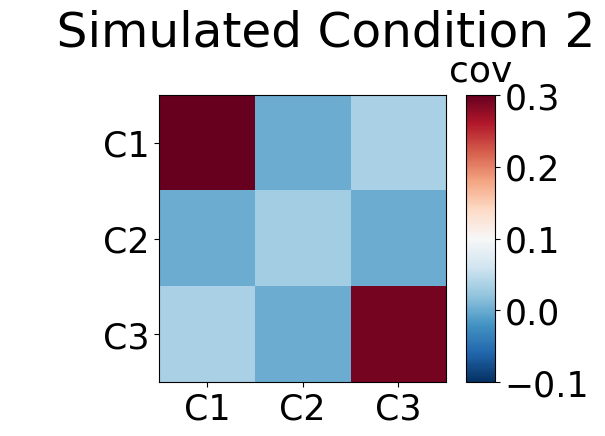

In [30]:
fig = plt.figure(figsize=(6,5))
ax = plt.subplot(111)
CM2 = mean_covariance(C2, metric='riemann')
im = ax.imshow(CM2, cmap='RdBu_r', vmin=-0.1, vmax=0.3) 
plt.title('   Simulated Condition 2', pad=35, fontsize=35)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='10%', pad=0.2)
cb = fig.colorbar(im, cax=cax)
cb.ax.set_title('cov', rotation=0, position=(0.5,0.5), pad=10, fontsize=26)
cb.ax.tick_params(labelsize=25) 
ax.set_xticks([0,1,2], labels=['C1', 'C2', 'C3'])
ax.set_yticks([0,1,2], labels=['C1', 'C2', 'C3'])
ax.tick_params(labelsize=25)
plt.tight_layout(pad=3)

Plotting a spectral embedding of spatial covariance matrices showing the high linear separability between simulated conditions when using covariance-based methods

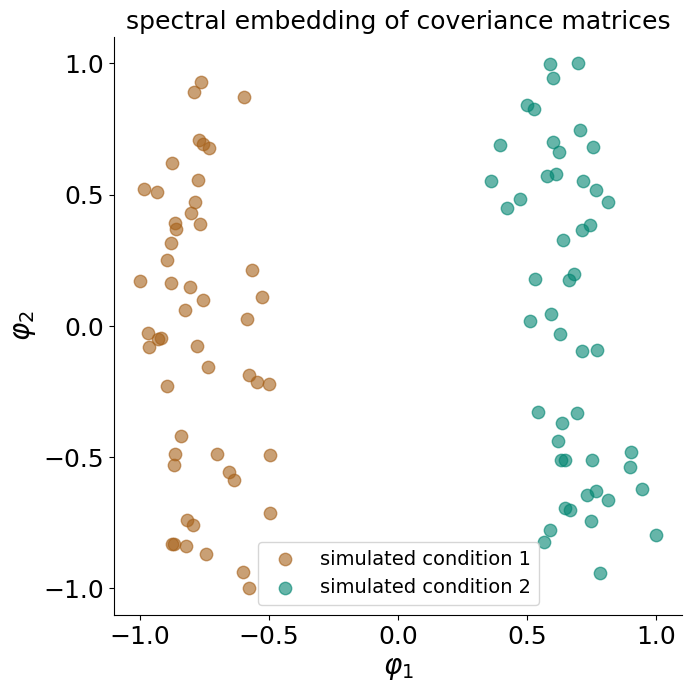

In [26]:
xs = np.concatenate([X1[:,:,1000:3000],X2[:,:,1000:3000]])
ys = np.concatenate(np.array([np.zeros(C1.shape[0]),np.ones(C1.shape[0])]))
nfilter = 6
xdwn = XdawnCovariances(estimator='oas', nfilter=nfilter)
split = train_test_split(xs, ys, train_size=0.5, random_state=42)
Xtrain, Xtest, ytrain, ytest = split
covs = xdwn.fit(Xtrain, ytrain).transform(Xtest)
lapl = SpectralEmbedding(n_components=2, metric='riemann')
embd = lapl.fit_transform(covs)
fig, ax = plt.subplots(figsize=(7, 7))
classonelabel = False
classtwolabel = False
for ii in range(100):
    if ytest[ii] == 0:
        if classonelabel == False:
            ax.scatter(embd[ii, 0], embd[ii, 1], s=80, color='#a6611a', alpha=0.6, label='simulated condition 1')
            classonelabel = True
        else:
            ax.scatter(embd[ii, 0], embd[ii, 1], s=80, color='#a6611a', alpha=0.6)
    else:
        if classtwolabel == False:
            ax.scatter(embd[ii, 0], embd[ii, 1], s=80, color='#018571', alpha=0.6, label='simulated condition 2')
            classtwolabel = True
        else:
            ax.scatter(embd[ii, 0], embd[ii, 1], s=80, color='#018571', alpha=0.6)
ax.set_xlabel(r"$\varphi_1$", fontsize=20)
ax.set_ylabel(r"$\varphi_2$", fontsize=20)
ax.grid(False)
ax.tick_params(labelsize=18)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xticks([-1.0, -0.5, 0.0, +0.5, 1.0])
ax.set_yticks([-1.0, -0.5, 0.0, +0.5, 1.0])
ax.legend(loc=0, fontsize=14)
ax.set_title('spectral embedding of coveriance matrices', fontsize=18)
plt.tight_layout(pad=1)

Plot a cosine similarity matrix showing the similarity between vector pairs in the covariance domain for each simulated condition

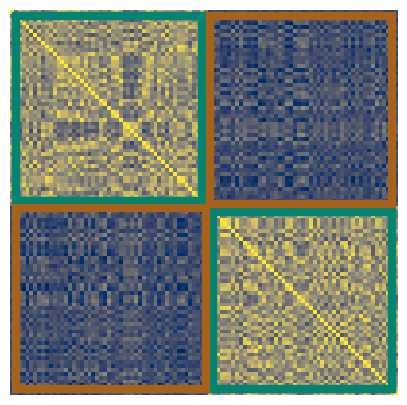

In [27]:
fig, ax = plt.subplots(figsize=(5, 5))
TS = TangentSpace(metric='riemann').fit_transform(covs[np.argsort(ytest)])
covsim = cosine_similarity(TS)
ax.imshow(covsim,cmap='cividis',aspect='auto')
ax.axis('off')
rect1 = patches.Rectangle((1, 1), 48, 48, linewidth=6, edgecolor='#018571', facecolor='none')
rect2 = patches.Rectangle((52, 52), 46, 46, linewidth=6, edgecolor='#018571', facecolor='none')
rect3 = patches.Rectangle((1, 51), 49, 47, linewidth=6, edgecolor='#a6611a', facecolor='none')
rect4 = patches.Rectangle((51, 1), 47, 49, linewidth=6, edgecolor='#a6611a', facecolor='none')
ax.add_patch(rect1)
ax.add_patch(rect2)
ax.add_patch(rect3)
ax.add_patch(rect4)

Plot a cosine similarity distribution showing the similarity between vector pairs in the time domain for each simulated condition

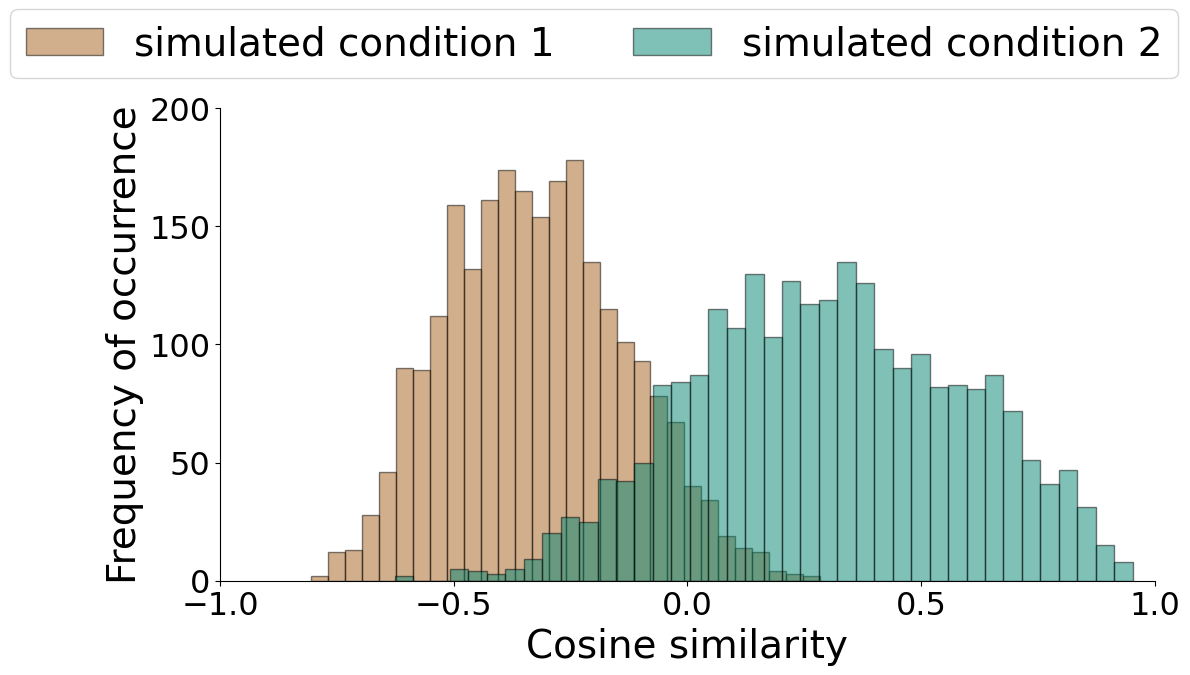

In [28]:
if simtype=='aligned':
    simpar = dict(bins=[16,52], ylim=[0,600], yticks=[0,100,200,300,400,500,600])
else:
    simpar = dict(bins=[30,40], ylim=[0,200], yticks=[0,50,100,150,200])
fig, ax = plt.subplots(figsize=(12, 7))
ax.hist(covsim[1:50,51:100].ravel(),bins=simpar['bins'][0],color='#a6611a',edgecolor='k',alpha=0.5, label='simulated condition 1')
ax.hist(np.concatenate((covsim[0:50,0:50][np.triu_indices(50,1)],covsim[50:100,50:100][np.triu_indices(50,1)])),bins=simpar['bins'][1],color='#018571',edgecolor='k',alpha=0.5, label='simulated condition 2')
ax.set_xlabel('Cosine similarity', fontsize=28)
ax.set_ylabel('Frequency of occurrence', fontsize=28)	
ax.tick_params(labelsize=25)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.tick_params(labelsize=23)
ax.set_ylim(simpar['ylim'])
ax.set_xlim([-1,1])
ax.set_yticks(simpar['yticks'])
ax.set_xticks([-1,-0.5,0,0.5,1])
ax.legend(loc=9,bbox_to_anchor=(0.4, 1.25),ncol=2,fontsize=28)
plt.tight_layout(pad=1)